# Bone age prediction of hand radiographs using Neural Networks

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [44]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import time

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 15)
# mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.fontsize'] = 'large'

%matplotlib inline
np.random.seed(1)

IMG_SIZE = 224
batch_size = 32
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 1)

## Retrieve datasets

In [3]:
import os
import zipfile

# Define the data folder location
path = '/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/'
data_dirs = ['Bone Age Training Set', 'Bone Age Validation Set','Bone Age Test Set']
train_dirs = ['boneage-training-dataset', 'dataset_data_file_training-gt-6aaa9791-5bdc-4c6d-9ee9-5a3780a37103']
val_dirs = ['boneage-validation-dataset-1', 'boneage-validation-dataset-2']

# Extract data from zip file
for data_dir in data_dirs:
  if not os.path.exists(data_dir):
  # if not os.path.exists(path + 'data/' + data_dir):
    with zipfile.ZipFile(path + data_dir + '.zip', 'r') as f:
      f.extractall('.')
      # f.extractall(path + 'data')
  if 'Training' in data_dir: # training set has two more zip files
    for train_dir in train_dirs:
      if not os.path.exists(train_dir):
        with zipfile.ZipFile(data_dir + '/' + train_dir + '.zip', 'r') as f:
          f.extractall('.')
      # if not os.path.exists(path + 'data/' + data_dir + '/' + train_dir):
      #   with zipfile.ZipFile(path + 'data/' + data_dir + '/' + train_dir + '.zip', 'r') as f:
      #     f.extract(path + data_dir)
  if 'Validation' in data_dir: # validation set is divided in two more zip files
    for val_dir in val_dirs:
      if not os.path.exists(val_dir):
        with zipfile.ZipFile(data_dir + '/' + val_dir + '.zip', 'r') as f:
          f.extractall('.')
      # if not os.path.exists(path + 'data/' + data_dir + '/' + val_dir):
      #   with zipfile.ZipFile(path + 'data/' + data_dir + '/' + val_dir + '.zip', 'r') as f:
      #     f.extractall(path + 'data/' + data_dir)

In [4]:
# !cp -R /content/boneage-training-dataset /content/boneage-training-masked
# !mkdir /content/boneage_training_masked
# !rm -r "/content/Bone Age Training Set"
# !mv "/content/Bone Age Validation Set/Validation Dataset.csv" /content
# !rm -r "/content/Bone Age Validation Set"

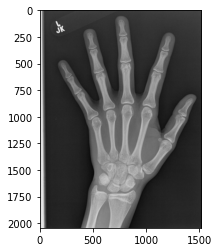

In [5]:
plt.imshow(cv2.imread(train_dirs[0] + '/1377.png'))

Mask an image as example

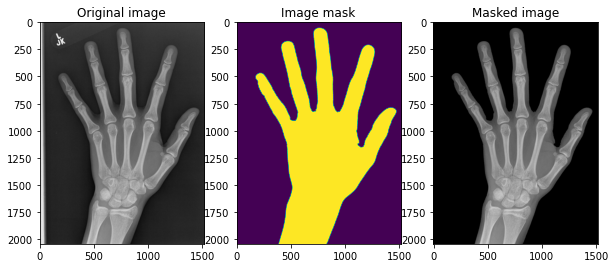

In [6]:
masks_path = 'boneage-training-dataset-masks'
image = cv2.imread(train_dirs[0] + '/1377.png')
mask = cv2.imread(path + '/' + masks_path + '/1377.png', 0)

fig, ax = plt.subplots(1,3, figsize=(10, 7))
ax[0].imshow(image)
ax[0].set_title('Original image')
ax[1].imshow(mask)
ax[1].set_title('Image mask')
ax[2].imshow(cv2.bitwise_and(image, image, mask=mask))
ax[2].set_title('Masked image')
plt.show()

## Creating dataframes

In [7]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/utils.py" utils.py
from utils import *

train_df = load_filenames('train.csv', train_dirs[0])
validation_df = load_filenames(data_dirs[1] + '/Validation Dataset.csv', val_dirs[0], val_dirs[1])
test_df = load_filenames(data_dirs[2] + '/Bone age ground truth.xlsx', data_dirs[2] + '/Test Set Images')

# normalize boneage value to accelerate training
mean_bone_age = train_df['boneage'].mean()
std_bone_age = train_df['boneage'].std()
train_df['boneage_n'] = (train_df['boneage'] - mean_bone_age) / std_bone_age
validation_df['boneage_n'] = (validation_df['boneage'] - mean_bone_age) / std_bone_age
test_df['boneage_n'] = (test_df['boneage'] - mean_bone_age) / std_bone_age

# number of steps between epochs
train_steps = int(np.ceil(train_df.shape[0] / batch_size))
val_steps = int(np.ceil(validation_df.shape[0] / batch_size))

In [8]:
# display(train_df[:5])
# display(validation_df[:5])
# display(test_df[:5])

## Data augmentation, Batching, Normalization

In [9]:
datagen_train = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen = gen_2inputs(datagen_train, train_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
val_gen = gen_2inputs(datagen_val, validation_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
test_gen = gen_2inputs(datagen_test, test_df, IMG_SIZE, test_df.shape[0])

In [10]:
# train_df['gender(M/F)'] = tf.convert_to_tensor(train_df['gender(M/F)'])
# train_df['boneage'] = tf.convert_to_tensor(train_df['boneage'])
# train_df['boneage_n'] = tf.convert_to_tensor(train_df['boneage_n'])

In [11]:
# train_df.columns = ['input_1', 'input_2', 'boneage', 'boneage_n']

In [12]:
# generator = datagen_train.flow_from_dataframe(dataframe=train_df,
#         x_col='image', y_col='boneage_n', batch_size=batch_size, seed=1, shuffle=True, class_mode='other',
#         target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale', drop_duplicates=False)

# dataset = tf.data.Dataset.from_generator(lambda: train_gen, output_types=({"input_1": tf.float32, "input_2": tf.float32}, tf.float32), 
#                                          output_shapes=({"input_1":(32, 244, 244, 1), "input_2":(32, )}, (32,)))

In [13]:
# for element in dataset.as_numpy_iterator():
#   print(element)

## Models for prediction

In [14]:
!rm models.py

rm: cannot remove 'models.py': No such file or directory


In [15]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/models.py" models.py
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/inc_v4.py" inc_v4.py
from models import *

epochs = 1

We use the mean absolute error as metric, as suggested in the papers

In [17]:
def mae_in_months(x, y):
    """
    Return mean absolute error in months

    Arguments:
    x -- predicted value
    y -- ground-truth
    """
    mean_bone_age = train_df['boneage'].mean()
    std_bone_age = train_df['boneage'].std()
    return mean_absolute_error((std_bone_age*x + mean_bone_age), (std_bone_age*y + mean_bone_age)) 

Create the callbacks for the fit function

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format('incV4') # change the name
# checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
#     save_best_only=True, mode='min', save_weights_only=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', 
                                min_delta=0.0001, cooldown=0, min_lr=0)

# callbacks = [checkpoint, early_stopping, reduce_lr]

### First place solution

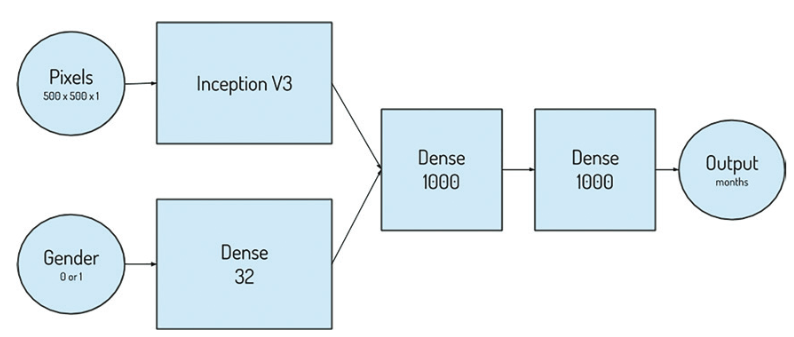

In [19]:
model_name = 'incV3'
gender = True
incV3_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

Found 12611 validated image filenames.
Found 12611 validated image filenames.
395/395 [==============================] - ETA: 0s - loss: 0.8460 - mae_in_months: 34.8380Found 1425 validated image filenames.
Found 1425 validated image filenames.

Epoch 1: val_loss improved from inf to 0.78249, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/incV3_weights.best.hdf5
395/395 [==============================] - 930s 2s/step - loss: 0.8460 - mae_in_months: 34.8380 - val_loss: 0.7825 - val_mae_in_months: 32.2246 - lr: 0.0010


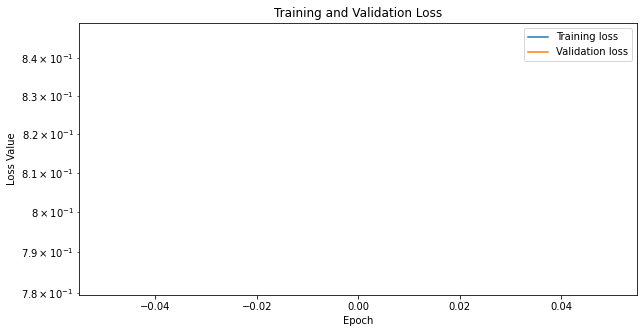

TRAINING FINISHED
Training time: 990.9717671871185
Loss: [0.8459505438804626]
MAE in months: [34.83796310424805]
Parameters: 31029273


<Figure size 432x288 with 0 Axes>

In [20]:
weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format(model_name)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
callbacks = [checkpoint, early_stopping, reduce_lr]

incV3_history, incV3_time = fit_boneage(incV3_model, train_gen, train_steps, val_gen, val_steps,
                                        epochs, callbacks, gender)

### InceptionV4
In this case we took the first-place solution replacing the Inception V3 model with an Inception V4, with the result of concatenating the 32-dimension vector corresponding to the gender with the pixels' vector of 75,264 dimensions (instead of 100,352)

In [21]:
model_name = 'incV4'
gender = True
incV4_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

395/395 [==============================] - ETA: 0s - loss: 0.8160 - mae_in_months: 33.6027
Epoch 1: val_loss improved from inf to 0.79569, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/incV4_weights.best.hdf5
395/395 [==============================] - 949s 2s/step - loss: 0.8160 - mae_in_months: 33.6027 - val_loss: 0.7957 - val_mae_in_months: 32.7680 - lr: 0.0010


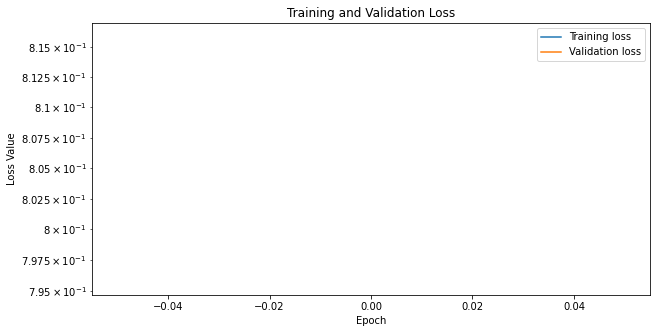

TRAINING FINISHED
Training time: 998.0906503200531
Loss: [0.815955638885498]
MAE in months: [33.602691650390625]
Parameters: 48416057


<Figure size 432x288 with 0 Axes>

In [22]:
weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format(model_name)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
callbacks = [checkpoint, early_stopping, reduce_lr]
incV4_history, incV4_time = fit_boneage(incV4_model, train_gen, train_steps, val_gen, val_steps,
                                        epochs, callbacks, gender)
# incV4_history, incV4_time = fit_boneage(incV4_model, train_gen, train_steps, val_gen, val_steps,
#                                         3, callbacks, path, gender=True)

In [ ]:
# incV4_model.save(path + 'models/{}-gender={}-epochs={}.h5'.format(incV4_model.name, True, 1))

In [ ]:
# print(incV4_history.history.keys())

### Simple CNN
Here we used a simple multi-layer convolution network 


In [23]:
model_name = 'simple_conv'
gender = True
simple_conv_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)
# tf.keras.utils.plot_model(simple_conv_model, show_shapes=True, dpi=64)

395/395 [==============================] - ETA: 0s - loss: 0.7811 - mae_in_months: 32.1662
Epoch 1: val_loss improved from inf to 0.77388, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/simple_conv_weights.best.hdf5
395/395 [==============================] - 882s 2s/step - loss: 0.7811 - mae_in_months: 32.1662 - val_loss: 0.7739 - val_mae_in_months: 31.8698 - lr: 0.0010


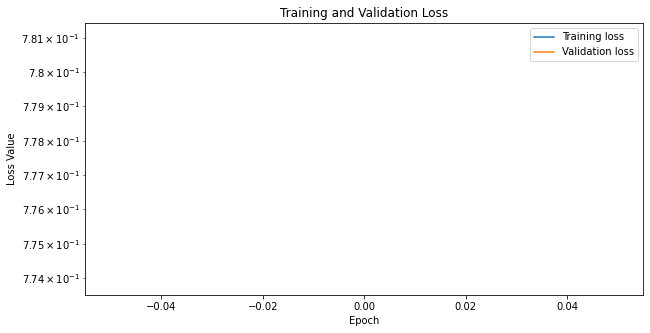

TRAINING FINISHED
Training time: 924.664466381073
Loss: [0.7810739278793335]
MAE in months: [32.16621398925781]
Parameters: 87655737


<Figure size 432x288 with 0 Axes>

In [24]:
weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format(model_name)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
callbacks = [checkpoint, early_stopping, reduce_lr]

simple_conv_history, simple_conv_time = fit_boneage(simple_conv_model, train_gen, train_steps, val_gen, val_steps,
                                                    epochs, callbacks, gender)

### VGG16

It seems to be one of the best architectures for image prediction

In [25]:
model_name = 'vgg16'
gender = True
vgg16_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

395/395 [==============================] - ETA: 0s - loss: 0.7775 - mae_in_months: 32.0204
Epoch 1: val_loss improved from inf to 0.78002, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/vgg16_weights.best.hdf5
395/395 [==============================] - 923s 2s/step - loss: 0.7775 - mae_in_months: 32.0204 - val_loss: 0.7800 - val_mae_in_months: 32.1229 - lr: 0.0010


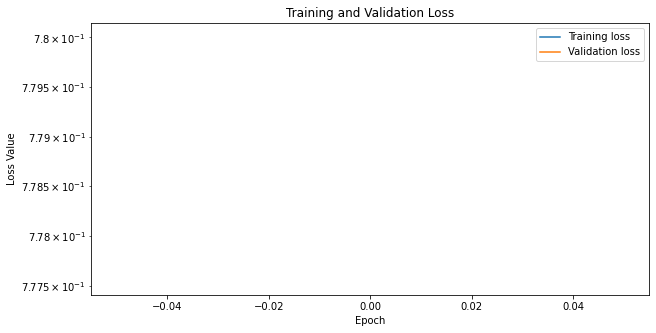

TRAINING FINISHED
Training time: 925.1514980792999
Loss: [0.7775327563285828]
MAE in months: [32.0203857421875]
Parameters: 116100601


<Figure size 432x288 with 0 Axes>

In [26]:
weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format(model_name)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
callbacks = [checkpoint, early_stopping, reduce_lr]

vgg16_history, vgg16_time = fit_boneage(vgg16_model, train_gen, train_steps, val_gen, val_steps,
                                        epochs, callbacks, gender)

## Model evaluation

In [ ]:
# used a fixed dataset for evaluating the algorithm
# test_X, test_Y = next(gen_2inputs(datagen_val, validation_df, IMG_SIZE, 1024, shuffle=True, seed=1))
test_X, test_Y = next(test_gen)

Found 1425 validated image filenames.
Found 1425 validated image filenames.


In [ ]:
pred_Y = std_bone_age * incV4_model.predict(test_X, batch_size = batch_size, verbose = True) + mean_bone_age
test_Y_months = std_bone_age * test_Y + mean_bone_age

32/32 [==============================] - 8s 160ms/step


Text(0, 0.5, 'Predicted Age (Months)')

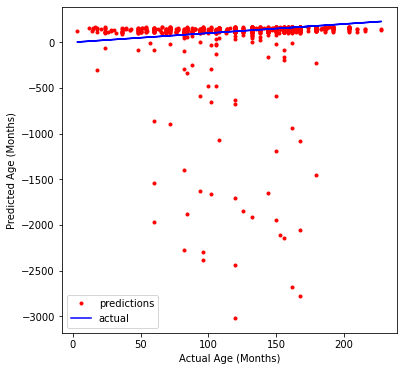

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(test_Y_months, pred_Y, 'r.', label = 'predictions')
ax1.plot(test_Y_months, test_Y_months, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')

In [ ]:
# model = create_model('inceptionV4', (IMG_SIZE, IMG_SIZE, 1), mae_in_months)
# model.load_weights(weight_path)

# # Evaluate the model
# loss, acc = model.evaluate(test_gen, verbose=2)
# print("model accuracy: {:5.2f}%".format(100 * acc))

Found 200 validated image filenames.
Found 200 validated image filenames.


In [ ]:
# # test_gen.reset()
# y_pred = incV4_model.predict(test_gen, steps=test_df.shape[0])
# predict = y_pred.flatten()
# predicted_months = mean_bone_age + std_bone_age*(predict)
# print("months predicted: {}, real boneage {}".format(str(predicted_months[i]),
#       str(test_df.loc[i, 'boneage'])) for i in range(len(predicted_months)))

## Model comparison

Plot #parameters

In [ ]:
bars = ['incV3', 'incV4', 'simple_conv', 'vgg16']
num_params = [incV3_model.count_params(), incV4_model.count_params(), 
              simple_conv_model.count_params(), vgg16_model.count_params()]
x_pos = np.arange(len(bars))

plt.bar(x_pos, num_params)
plt.xticks(x_pos, bars)
plt.title('# Parameters per model')
plt.xlabel('Models')
plt.ylabel('# Parameters')
plt.show()

Plot training time

In [ ]:
tr_times = [incV3_time, incV4_time, simple_conv_time, vgg16_time]

plt.bar(x_pos, tr_times)
plt.xticks(x_pos, bars)
plt.title('Training time per model')
plt.xlabel('Models')
plt.ylabel('Training times')
plt.show()

Plot accuracy/loss

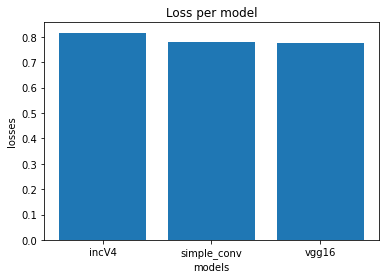

In [32]:
losses = [incV3_history.history['loss'][-1], incV4_history.history['loss'][-1], 
          simple_conv_history.history['loss'][-1], vgg16_history.history['loss'][-1]] 

plt.bar(x_pos, losses)
plt.xticks(x_pos, bars)
plt.title('Loss per model')
plt.xlabel('Models')
plt.ylabel('Losses')
plt.show()

Plot MAE

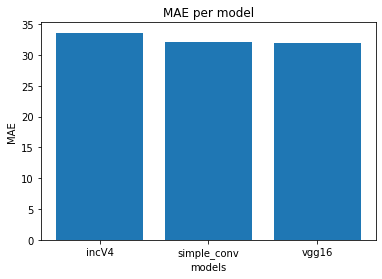

In [33]:
maes = [incV3_history.history['mae_in_months'][-1], incV4_history.history['mae_in_months'][-1], 
          simple_conv_history.history['mae_in_months'][-1], vgg16_history.history['mae_in_months'][-1]]

plt.bar(x_pos, maes)
plt.xticks(x_pos, bars)
plt.title('MAE per model')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.show()

Plot memory

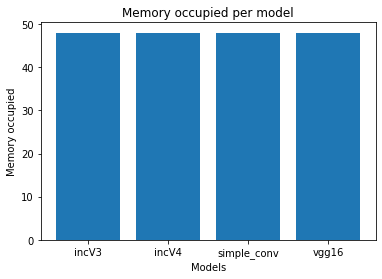

In [45]:
import sys

incV3_memory = sys.getsizeof(incV3_model)
incV4_memory = sys.getsizeof(incV4_model)
simple_conv_memory = sys.getsizeof(simple_conv_model)
vgg16_memory = sys.getsizeof(vgg16_model)
memories = [incV3_memory, incV4_memory, simple_conv_memory, vgg16_memory]

bars=['incV3', 'incV4', 'simple_conv', 'vgg16']
x_pos = np.arange(len(bars))

plt.bar(x_pos, memories)
plt.xticks(x_pos, bars)
plt.title('Memory occupied per model')
plt.xlabel('Models')
plt.ylabel('Memory occupied')
plt.show()

## Gender assesment

We want also to see what changes in terms of learning time and accuracy, when the gender data changes.

### No gender

In [ ]:
# reset generators in order to restart from the first batch
# train_gen.reset()
# val_gen.reset()
# test_gen.reset()

# train_gen = gen_2inputs(datagen_train, train_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
# val_gen = gen_2inputs(datagen_val, validation_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
# test_gen = gen_2inputs(datagen_test, test_df, IMG_SIZE, test_df.shape[0])

In [ ]:
model_name = 'incV4'
gender = False
incV4_nogender = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

In [ ]:
epochs = 1
incV4_nogender_history, incV4_nogender_time = fit_boneage(incV4_nogender, train_gen, train_steps, val_gen, val_steps,
                                                          epochs, callbacks, gender)

### Males only

In [ ]:
# filtering new dataframes
train_df_M = train_df[train_df['gender(M/F)'] == 1]
validation_df_M = validation_df[validation_df['gender(M/F)'] == 1]
test_df_M = test_df[test_df['gender(M/F)'] == 1]

# number of steps between epochs
train_steps_M = int(np.ceil(train_df_M.shape[0] / batch_size))
val_steps_M = int(np.ceil(validation_df_M.shape[0] / batch_size))

print(train_df_M.shape[0], validation_df_M.shape[0], test_df_M.shape[0])

6833 773 100


In [ ]:
# new generators
datagen_train_M = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val_M = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test_M = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen_M = gen_2inputs(datagen_train_M, train_df_M, IMG_SIZE, batch_size, shuffle=True, seed=1)
val_gen_M = gen_2inputs(datagen_val_M, validation_df_M, IMG_SIZE, batch_size, shuffle=True, seed=1)
test_gen_M = gen_2inputs(datagen_test_M, test_df_M, IMG_SIZE, test_df_M.shape[0])

In [ ]:
model_name = 'incV4'
gender = False
incV4_M = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

Found 6833 validated image filenames.
Found 6833 validated image filenames.
214/214 [==============================] - ETA: 0s - loss: 0.9575 - mae_in_months: 39.4314Found 773 validated image filenames.
Found 773 validated image filenames.

Epoch 1: val_loss did not improve from 0.76825
214/214 [==============================] - 538s 2s/step - loss: 0.9575 - mae_in_months: 39.4314 - val_loss: 0.9347 - val_mae_in_months: 38.4920 - lr: 0.0010


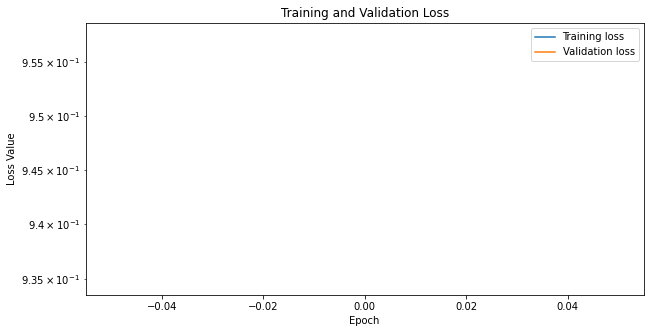

TRAINING FINISHED
Training time: 578.2401781082153
Loss: [0.9574896097183228]
MAE in months: [39.43135452270508]
Parameters: 48383993


In [ ]:
epochs = 1
incV4_M_history, incV4_M_time = fit_boneage(incV4_M, train_gen_M, train_steps_M, val_gen_M, val_steps_M,
                                            epochs, callbacks, 'Male')

### Females only

In [ ]:
# filtering new dataframes
train_df_F = train_df[train_df['gender(M/F)'] == 0]
validation_df_F = validation_df[validation_df['gender(M/F)'] == 0]
test_df_F = test_df[test_df['gender(M/F)'] == 0]

# number of steps between epochs
train_steps_F = int(np.ceil(train_df_F.shape[0] / batch_size))
val_steps_F = int(np.ceil(validation_df_F.shape[0] / batch_size))

print(train_df_F.shape[0], validation_df_F.shape[0], test_df_F.shape[0])

5778 652 100


In [ ]:
# new generators
datagen_train_F = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val_F = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test_F = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen_F = gen_2inputs(datagen_train_F, train_df_F, IMG_SIZE, batch_size, shuffle=True, seed=1)
val_gen_F = gen_2inputs(datagen_val_F, validation_df_F, IMG_SIZE, batch_size, shuffle=True, seed=1)
test_gen_F = gen_2inputs(datagen_test_F, test_df_F, IMG_SIZE, test_df_F.shape[0])

In [ ]:
model_name = 'incV4'
gender = False
incV4_F = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

Found 5778 validated image filenames.
Found 5778 validated image filenames.
181/181 [==============================] - ETA: 0s - loss: 0.8926 - mae_in_months: 36.7585Found 652 validated image filenames.
Found 652 validated image filenames.

Epoch 1: val_loss did not improve from 0.76825
181/181 [==============================] - 434s 2s/step - loss: 0.8926 - mae_in_months: 36.7585 - val_loss: 0.8156 - val_mae_in_months: 33.5877 - lr: 0.0010


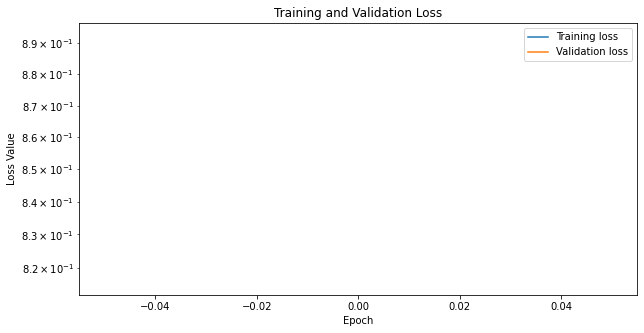

TRAINING FINISHED
Training time: 458.035108089447
Loss: [0.892586350440979]
MAE in months: [36.758514404296875]
Parameters: 48383993


In [ ]:
epochs = 1
incV4_F_history, incV4_F_time = fit_boneage(incV4_F, train_gen_F, train_steps_F, val_gen_F, val_steps_F,
                                            epochs, callbacks, 'Female')

## Attention mechanism

In [ ]:
X = Input(IMG_SHAPE)
base_pretrained_model = VGG16(input_shape =  IMG_SHAPE, include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(X)

bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off
attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = tf.keras.layers.LocallyConnected2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', activation = 'linear',
               use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = tf.keras.layers.multiply([attn_layer, bn_features])
gap_features = tf.keras.layers.GlobalAveragePooling2D()(mask_features)
gap_mask = tf.keras.layers.GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = tf.keras.layers.Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(1024, activation = 'elu')(gap_dr))

out_layer = Dense(1, activation = 'linear')(dr_steps)
attention_model = Model(inputs = [X], outputs = [out_layer])

attention_model.compile(optimizer = 'adam', loss = 'mse', metrics = [mae_in_months])

In [ ]:
# create generators without merging with gender data
train_gen = datagen_train.flow_from_dataframe(dataframe=train_df,
        x_col='image', y_col='boneage_n', batch_size=batch_size, seed=1, shuffle=True, class_mode='other',
        target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale', drop_duplicates=False)

In [ ]:
attention_model.fit_generator(train_gen, validation_data = (test_X, test_Y), epochs = 15, callbacks = callbacks)